In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

In [3]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

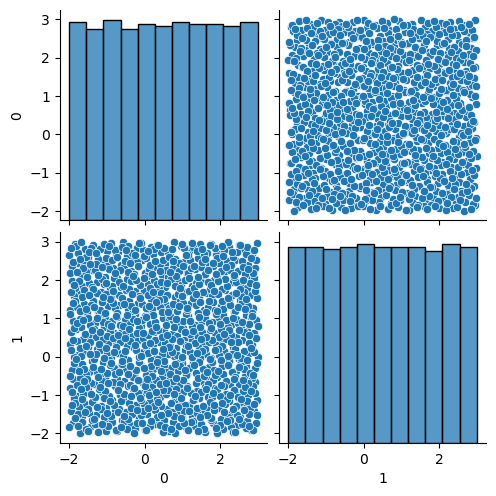

In [4]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [5]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function

coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.1)
dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [6]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [7]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = coexbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)

results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 0.000e+00
21) Best value: 5.12641e+00
1) parameters: beta 8.000e-01 gamma 1.000e-02
22) Best value: 5.12641e+00
2) parameters: beta 9.798e-01 gamma 4.000e-02
23) Best value: 7.60111e+00
3) parameters: beta 1.131e+00 gamma 9.000e-02
24) Best value: 8.48490e+00
4) parameters: beta 1.265e+00 gamma 1.600e-01
25) Best value: 1.01950e+01
5) parameters: beta 1.386e+00 gamma 2.500e-01
26) Best value: 1.01950e+01
6) parameters: beta 1.497e+00 gamma 3.600e-01
27) Best value: 1.05405e+01
7) parameters: beta 1.600e+00 gamma 4.900e-01
28) Best value: 1.05980e+01
8) parameters: beta 1.697e+00 gamma 6.400e-01
29) Best value: 1.06030e+01
9) parameters: beta 1.789e+00 gamma 8.100e-01
30) Best value: 1.06030e+01


# Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [8]:
results

tensor([[3.5184e+00, 5.1264e+00, 1.5109e-02, 6.1881e-01],
        [3.2878e+00, 5.1264e+00, 4.0315e-01, 6.1765e-01],
        [4.4151e+00, 7.6011e+00, 4.7971e-03, 6.1650e-01],
        [3.7430e+00, 8.4849e+00, 1.1860e-02, 6.1058e-01],
        [3.6104e+00, 1.0195e+01, 1.0106e-02, 6.1429e-01],
        [2.7140e+00, 1.0195e+01, 1.0806e-02, 6.0849e-01],
        [3.7465e+00, 1.0540e+01, 2.0242e-03, 6.0280e-01],
        [3.5824e+00, 1.0598e+01, 1.6333e-04, 5.9722e-01],
        [3.5102e+00, 1.0603e+01, 4.6809e-05, 5.9174e-01],
        [4.1806e+00, 1.0603e+01, 4.8989e-05, 5.8636e-01]])